**Analysis of sales of computer games** 

Perform an analysis of historical data on global sales of computer games, user and expert ratings up to 2016 and identify patterns that determine the success of games. The results will help you identify a potential product and plan advertising campaigns in the coming year. 
1. Before starting the analysis, perform data preprocessing: process omissions, duplicates, convert data to the required types. Calculate total sales in all regions.
2. Conduct exploratory data analysis:
- see how many games were released in different years, how sales changed by platform; 
- select platforms with the highest total sales and build distribution by years; 
- determine the current period for building a forecast for 2017;
- see which platforms are leading in sales, select several potentially profitable platforms;
- build a box-and-mustache plot of global game sales by platform;
- evaluate the impact on sales within one popular platform reviews from users and critics;
- build a scatterplot and calculate the correlation between reviews and sales; 
- correlate findings with sales of games on other platforms;
- analyze the overall distribution of games by genre, determine the most profitable ones, highlight genres with high and low sales.
3. Create a user profile for each region:
- identify the most popular platforms (top 5), explain differences in sales shares;
- identify the most popular genres (top 5), explain the difference;
- determine the impact of the ESRB rating on sales in each region;
4. Test hypotheses:
- the average user ratings of the Xbox One and PC platforms are the same;
- average user ratings for the Action and Sports genres are different.
5. Formulate a general conclusion.





<b>1. Loading data and displaying general information:</b> </div>

In [1]:
import pandas as pd
import warnings
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from scipy import stats as st


In [13]:
data = pd.read_csv('/datasets/games.csv')

display(data.head(10))

data.info() 

display(data.isna().sum())

display(pd.DataFrame(round(data.isna().mean()*100, 1)).style)

,Name,Platform,Year_of_Release,Genre,NA_sales,EU_sales,JP_sales,Other_sales,Critic_Score,User_Score,Rating
0,Wii Sports,Wii,2006.0,Sports,41.36,28.96,3.77,8.45,76.0,8,E
1,Super Mario Bros.,NES,1985.0,Platform,29.08,3.58,6.81,0.77,NaN,NaN,NaN
2,Mario Kart Wii,Wii,2008.0,Racing,15.68,12.76,3.79,3.29,82.0,8.3,E
3,Wii Sports Resort,Wii,2009.0,Sports,15.61,10.93,3.28,2.95,80.0,8,E
4,Pokemon Red/Pokemon Blue,GB,1996.0,Role-Playing,11.27,8.89,10.22,1.00,NaN,NaN,NaN
5,Tetris,GB,1989.0,Puzzle,23.20,2.26,4.22,0.58,NaN,NaN,NaN
6,New Super Mario Bros.,DS,2006.0,Platform,11.28,9.14,6.50,2.88,89.0,8.5,E
7,Wii Play,Wii,2006.0,Misc,13.96,9.18,2.93,2.84,58.0,6.6,E
8,New Super Mario Bros. Wii,Wii,2009.0,Platform,14.44,6.94,4.70,2.24,87.0,8.4,E
9,Duck Hunt,NES,1984.0,Shooter,26.93,0.63,0.28,0.47,NaN,NaN,NaN


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 16715 entries, 0 to 16714
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   Name             16713 non-null  object 
 1   Platform         16715 non-null  object 
 2   Year_of_Release  16446 non-null  float64
 3   Genre            16713 non-null  object 
 4   NA_sales         16715 non-null  float64
 5   EU_sales         16715 non-null  float64
 6   JP_sales         16715 non-null  float64
 7   Other_sales      16715 non-null  float64
 8   Critic_Score     8137 non-null   float64
 9   User_Score       10014 non-null  object 
 10  Rating           9949 non-null   object 
dtypes: float64(6), object(5)
memory usage: 1.4+ MB


Name                  2
Platform              0
Year_of_Release     269
Genre                 2
NA_sales              0
EU_sales              0
JP_sales              0
Other_sales           0
Critic_Score       8578
User_Score         6701
Rating             6766
dtype: int64

,0
Name,0.000000
Platform,0.000000
Year_of_Release,1.600000
Genre,0.000000
NA_sales,0.000000
EU_sales,0.000000
JP_sales,0.000000
Other_sales,0.000000
Critic_Score,51.300000
User_Score,40.100000


<b>2. Data preparation</b> </div>



In [22]:
data.columns = data.columns.str.lower()


In [23]:
data_old = data.shape[0]

data = data.drop(index=data.query('year_of_release.isna() or name.isna()').index)


In [24]:
data['year_of_release'] = data['year_of_release'].astype('int64')
data['user_score'] = np.floor(pd.to_numeric(data['user_score'], errors='coerce')).astype('float64')

data['rating'] = data['rating'].fillna(value='Unknown')

data = data.fillna({'critic_score': -1, 'user_score': -1})

print('Количество явных дубликатов:', data.duplicated().sum())




Number of explicit duplicates: 0


In [25]:
# make sure the gaps in the columns are handled:
display(data.isna().sum())

# display the amount of deleted data:
data_new = data.shape[0]
result = (1 - (data_new / data_old))
print(f'Доля удаленных данных составила: {result:.1%}')



name               0
platform           0
year_of_release    0
genre              0
na_sales           0
eu_sales           0
jp_sales           0
other_sales        0
critic_score       0
user_score         0
rating             0
dtype: int64

Доля удаленных данных составила: 1.6%


According to the analysis of the initial data, gaps were found in the data in 6 columns out of 11. The largest share of gaps is contained in the columns: critic_score - 51%, user_score - 40%, rating - 41%.

- there is a tbd (to be determined) value in the user_score column, which means that the decision on the issue has not been made. This value has been replaced with Nan (no data);
- since the proportion of gaps in the critic_score and user_score columns is half of the entire sample and these data will be used in the analysis in the future, the data cannot be deleted. In this regard, it was decided to fill the gaps in these columns with the value -1 (stub);
- gaps in the rating column replaced with Unknown;
-blanks from the name and year_of_release columns have been removed, due to their insignificant number (2 lines). 
-no explicit duplicates found in data.

As a result of data preprocessing, the share of deleted data was 1.6%.

The data in the year_reliase float column has been converted to an int because the year is an integer. 
The data in the user_score column of type Object has been converted to the float data type because user scores are usually real floating point numbers.

<div class="alert alert-block alert-warning">
 
### Комментарий ревьюера
    
#### Совет
    
Для экономии вычислительной памяти лучше всего переводить в int32 или float32 
</div 

<div class="alert alert-block alert-success">
 
### Комментарий ревьюера
    
#### Успех
    
Подробные и обоснованные выводы у тебя получились. Идем дальше. 
</div 

In [26]:
#Посчитаем суммарные продажи во всех регионах и запишим их в отдельный столбец:

data['total_sales'] = (data['na_sales'] + data['eu_sales'] + data['jp_sales'] + data['other_sales'])



<div class="alert alert-block alert-success">
 
### Комментарий ревьюера
    
#### Успех
    
А еще можешь такой способ использовать `df['f'] = df[['a','b','c','d']].sum(axis=1)`
</div 

<b>3. Исследовательский анализ данных</b> </div>

- Посмотреть, сколько игр выпускалось в разные годы. Важны ли данные за все периоды?
- Посмотреть, как менялись продажи по платформам. Выбрать платформы с наибольшими суммарными продажами и построить распределение по годам. За какой характерный срок появляются новые и исчезают старые платформы?
- Взять данные за соответствующий актуальный период и посмотреть какие платформы лидируют по продажам, растут или падают? Выбрать несколько потенциально прибыльных платформ.
- Построить график «ящик с усами» по глобальным продажам игр в разбивке по платформам,описать результат.
- Посмотреть, как влияют на продажи внутри одной популярной платформы отзывы пользователей и критиков. Построить диаграмму рассеяния и посчитать корреляцию между отзывами и продажами. Сформулировать выводы.
- Соотнести выводы с продажами игр на других платформах.
- Посмотреть на общее распределение игр по жанрам. Что можно сказать о самых прибыльных жанрах? Выделяются ли жанры с высокими и низкими продажами?

Text(0, 0.5, 'количество игр')

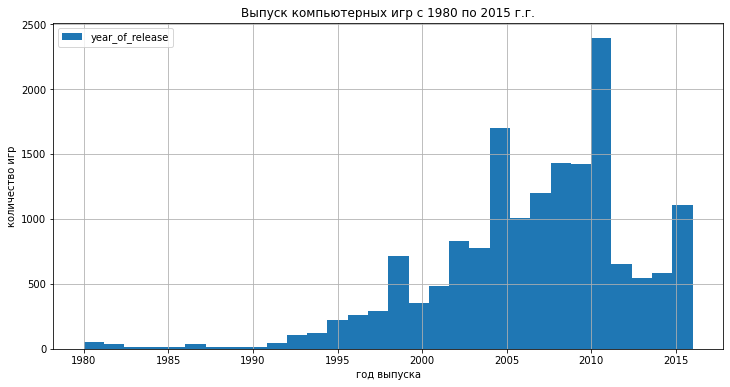

In [30]:
#Посмотрим, сколько игр выпускалось в разные годы:
data.plot(kind='hist', y='year_of_release',bins=30,  figsize=(12,6),  title='Выпуск компьютерных игр с 1980 по 2015 г.г.', grid=True) 

plt.xlabel('год выпуска')
plt.ylabel('количество игр')



<div class="alert alert-block alert-success">
 
### Комментарий ревьюера
    
#### Успех
    
Классный график у тебя получился, который показывает реальную картину выпуска платформ. 
</div 

Полученная гистограмма отображает общее количество компьютерных игр, выпущенных в период с 1980 до 2015 г.г. Согласно гистограмме развитие индустрии компьютерных игр началось после 1990 года. Выпуск игр достиг максимума в 2010-2011 г.г. Поэтому данные ранее 2000 года уже потеряли актуальность.


Text(0.5, 1.0, 'Изменение продаж по платформам')

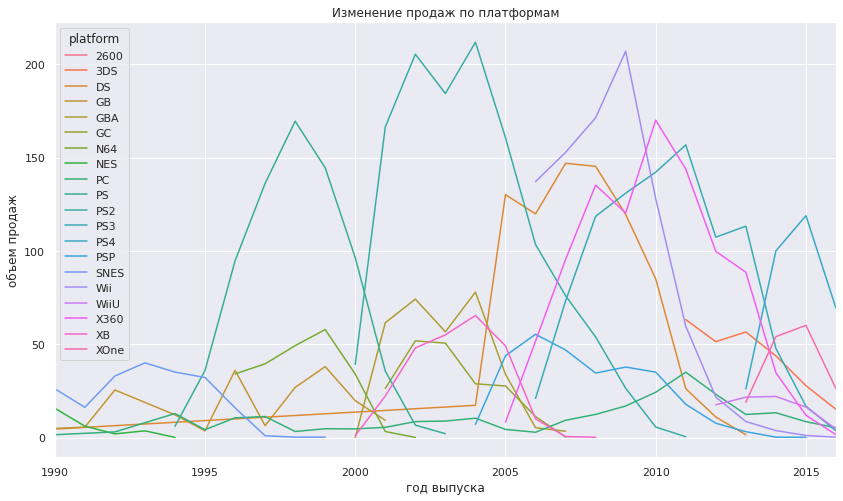

In [31]:
#Выберим платформы top_20 с наибольшими суммарными продажами:
top_platform = (data           
                    .groupby('platform')['total_sales'].agg('sum').reset_index()
                    .sort_values(by='total_sales', ascending=False)
                    .head(20))

list_top_platform = top_platform['platform'].to_list()

           

#построим  распределение платформ с наибольшими сумарными продажами по годам:

plot_top_platform = (data.query('platform in @list_top_platform')
                          .pivot_table(index=['platform', 'year_of_release'], values='total_sales', aggfunc='sum').reset_index()
                         
                    )

sns.set(rc={'figure.figsize':(14,8)})
sns.lineplot(data=plot_top_platform, x='year_of_release', y='total_sales', hue='platform')

plt.xlim(1990,2016)
plt.xlabel('год выпуска')
plt.ylabel('объем продаж')
plt.title('Изменение продаж по платформам')




<div class="alert alert-block alert-success">
 
### Комментарий ревьюера
    
#### Успех
    
И снова хочу похвалить тебя за хорошую и понятную визуализацию платформ. 
</div 

В результате отбора 20 платформ с наибольшими суммарными продажами построено распределение продаж по годам. В соответствии с полученным графиком появление новых платформ и исчезновение старых происходит примерно каждые 10 лет. Большинство платформ с наибольшими суммарными продажами появились и исчезали в последние 10 лет. Таким образом, для проведения дальнейшего анализа, актуальным периодом будем считать 2014-2016 г.г.

Text(0.5, 1.0, 'Суммарные продажи за 2014-2016 г.г.')

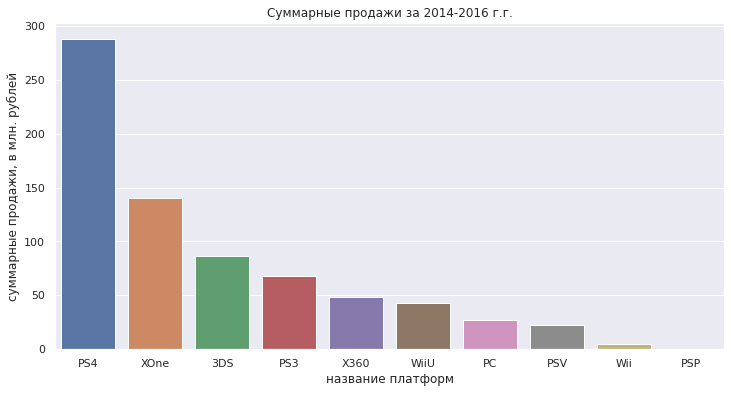

In [33]:
# оставим данные за актуальный период и найдем какие платформы лидировали по продажам:
new_data = (data.query('year_of_release in [2014, 2015, 2016]')
                .pivot_table(index='platform', values=['total_sales'], aggfunc='sum').reset_index()
                .sort_values(by='total_sales', ascending=False)
           )

sns.set(rc={'figure.figsize':(12,6)})
sns.barplot(data=new_data, x='platform', y='total_sales')           
plt.xlabel('название платформ')
plt.ylabel('суммарные продажи, в млн. рублей')
plt.title('Суммарные продажи за 2014-2016 г.г.')




<div class="alert alert-block alert-success">
 
### Комментарий ревьюера
    
#### Успех
    
Тут и список лидеров определили. Супер. 
</div 

Согласно графику, лидерами продаж на протяжении последних трех лет являются две платформы: PS4 и XOne, поэтому будем считать, что они являются потенциально прибыльными. 

Text(0.5, 1.0, 'Диаграмма размаха по глобальным продажам игр в разбивке по  двум потенциально прибыльным платформам')

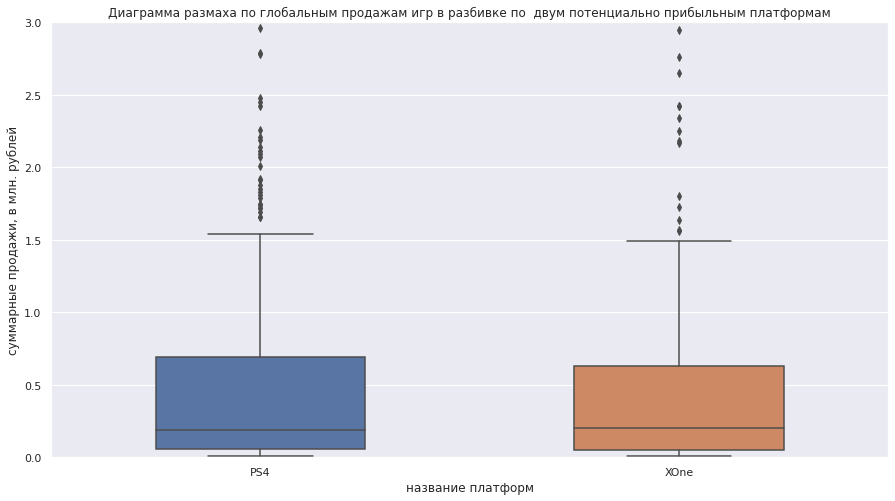

In [34]:
#построим график "ящик с усами" по глобальным продажам в разбивке по двум потенциально прибыльным платформам:

data_graph = data.query('year_of_release >= 2014 and platform in ["PS4", "XOne"]')

fig = plt.gcf()
fig.set_size_inches(15,8)
sns.boxplot(data=data_graph, x='platform', y='total_sales', width=0.5)
plt.ylim(0,3)
plt.xlabel('название платформ')
plt.ylabel('суммарные продажи, в млн. рублей')
plt.title('Диаграмма размаха по глобальным продажам игр в разбивке по  двум потенциально прибыльным платформам')


<div class="alert alert-block alert-success">
 
### Комментарий ревьюера
    
#### Успех
    
Отдельно хочу похвалить за то, что ты ограничила вывод выбросов и мы видим отчетливо медиану и квантили. 
</div 

Диаграмма размаха показывает, что ориентировочная граница нормального размаха заканчивается для платформы PS4 на значении 1,6 млн. рублей, для платформы XOne - 1,5 млн. рублей. Все значения, которые находятся выше этих значений являются выбросами. При этом степень разброса за пределами верхнего квартиля по обеим платформам намного больше, чем за пределами нижнего. 
Данные смещены в сторону меньших значений, так как медианы обеих платформ равны примерно 0,2 млн рублей и стремляться к короткому хвосту меньших значений. При этом 25% суммарных продаж по каждой платформе примерно равны 0,05 млн рублей. В то время как 75% суммарных продаж платформы PS4 равны 0,7 млн рублей, а платформы XOne - 0,6 млн рублей.


Корреляция между отзывами пользователей и продажами = 0.14
Корреляция между отзывами критиков и продажами = 0.15


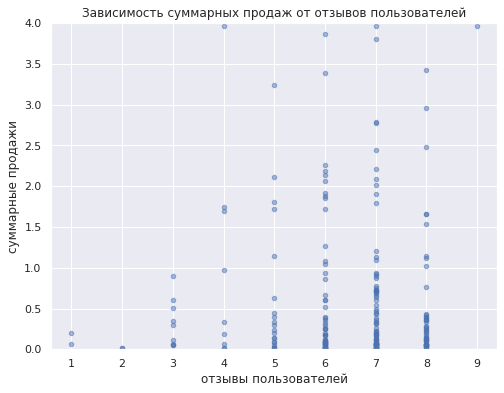

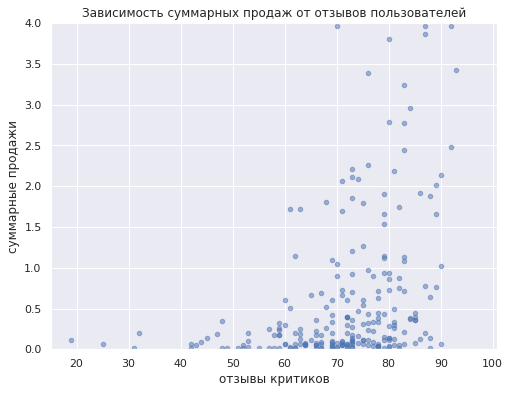

In [37]:
from matplotlib.axes._axes import _log as matplotlib_axes_logger
matplotlib_axes_logger.setLevel('ERROR')

#построим диаграмму рассеяния зависимости продаж от отзывов пользователей внутри найденной популярной платформы PS4:
(data
     .query('platform == "PS4" and year_of_release >= 2014 and user_score >= 0') \
      [['user_score', 'total_sales']] \
     .plot(x='user_score', y='total_sales', kind='scatter', figsize=(8,6), alpha=0.5, grid=True, title='Зависимость cуммарных продаж от отзывов пользователей')
)

plt.xlabel('отзывы пользователей')
plt.ylabel('суммарные продажи')
plt.ylim(0,4)

#построим диаграмму рассеяния зависимости продаж от отзывов критиков внутри найденной популярной платформы PS4:
(data
     .query('platform == "PS4" and year_of_release >= 2014 and critic_score >= 0') \
      [['critic_score', 'total_sales']] \
     .plot(x='critic_score', y='total_sales', kind='scatter', figsize=(8,6),alpha=0.5, grid=True, title='Зависимость cуммарных продаж от отзывов пользователей')
)

plt.xlabel('отзывы критиков')
plt.ylabel('суммарные продажи')
plt.ylim(0,4)

#посчитаем корреляцию между отзывами и продажами:
print('Корреляция между отзывами пользователей и продажами =', data['total_sales'].corr(data['user_score']).round(2))
print('Корреляция между отзывами критиков и продажами =',data['total_sales'].corr(data['critic_score']).round(2))


<div class="alert alert-block alert-success">
 
### Комментарий ревьюера
    
#### Успех
    
Потрясающий метод для вывода зависимостей на графике. Еще отмечу, что не забыла устранить значения заглушки, а это важно. 
</div 

<div class="alert alert-block alert-warning">
 
### Комментарий ревьюера
    
#### Совет
    
Импорт всех библиотек принято делать в самом начале проекта в общей ячейке кода. 
</div 

По результатам анализа построенных диаграмм, а также исходя из полученных коэффициентов корреляции Пирсона можно сделать вывод, что зависимость между суммарными продажами и отзывами пользователей положительная, но очень слабая, так как значение коэффициента близко к нулю (corr=0,14-0,15).


Text(0.5, 1.0, 'Диаграмма размаха по суммарным продажам игр по всем платформам')

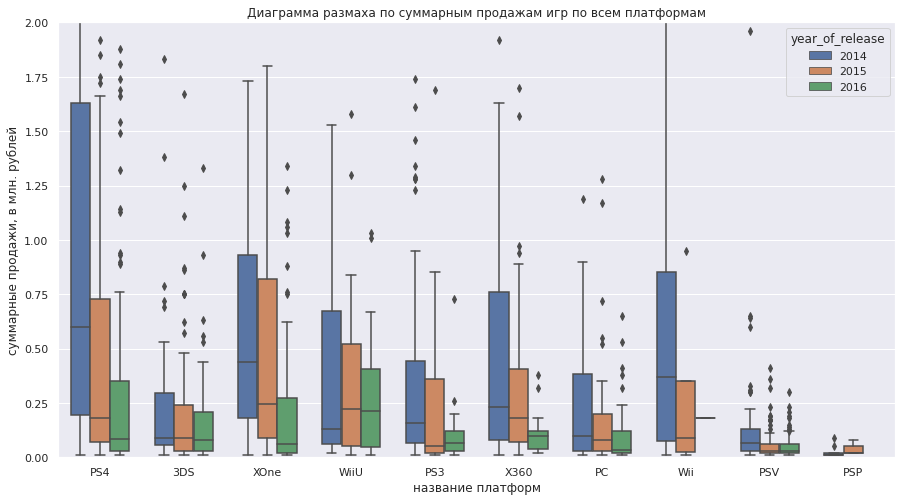

In [38]:
#сравним как суммарные продажи менялись на других платформах по годам:
sum_sales_platforms = data.query('year_of_release in [2014, 2015, 2016]')
                          
fig = plt.gcf()
fig.set_size_inches(15,8)

sns.boxplot(data=sum_sales_platforms, x='platform', y='total_sales', hue='year_of_release',  width=0.7)

plt.ylim(0,2)
plt.xlabel('название платформ')
plt.ylabel('суммарные продажи, в млн. рублей')
plt.title('Диаграмма размаха по суммарным продажам игр по всем платформам')



<div class="alert alert-block alert-success">
 
### Комментарий ревьюера
    
#### Успех
    
И тут вышло очень информативно. 
</div 

Согласно диаграмме размаха динамика суммарных продаж платформ-лидеров и остальных платформ за последних 3 года была следующей:
Медианные оценки суммарных продаж платформ-лидеров PS4 и XOne в 2014 году были максимальными среди всех платформ, после чего в 2015-2016 годах резко сократились, сравнявшись с уровнем суммарных продаж таких платформ как 3DS, PS3. При этом медианная оценка суммарных продаж платформы 3DS остается стабильной в течение уже трех лет. Также остается относительно стабильной в течение последних двух лет и медианная оценка суммарных продаж платформы WiiU, при этом в 2016 году данная платформа вышла в лидеры по суммарным продажам, обогнав остальных участников.  







Text(0.5, 1.0, 'Распределение игр по жанрам')

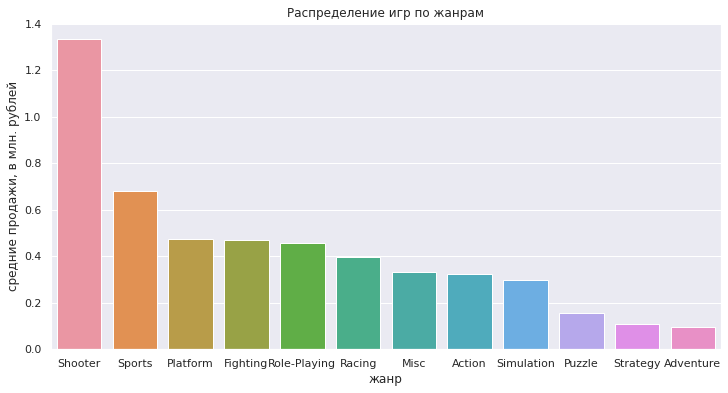

In [53]:
#построим общее распределение игр по жанрам:
genre_games =(sum_sales_platforms
                                .pivot_table(index='genre', values='total_sales', aggfunc='mean').reset_index()
                                .sort_values(by='total_sales', ascending=False)               
            )

  
sns.set(rc={'figure.figsize':(12,6)})
sns.barplot(data=genre_games, x='genre', y='total_sales')           
plt.xlabel('жанр')
plt.ylabel('средние продажи, в млн. рублей')
plt.title('Распределение игр по жанрам')




Согласно графику среди общего количества продаж игра жанра Shooter является самой прибыльной, средние продажи которой составили 1,3 млн рублей. Второе место занимает игра жанра Sports со средними продажами примерно 0,7 млн рублей. Средние продажи игр жанров Platform, Fighting, Pole-Playing, Racing находились примерно на одном уровне и составляли 0,5 млн. рублей. К самым неприбыльным жанрам можно отнести Puzzle, Strategy и Puzzle со средними продажами менее 0,2 млн. рублей.   





<div class="alert alert-block alert-success">
 
### Комментарий ревьюера
    
#### Успех
    
Ты правильно сделала, что рассмотрела именно средние продажи. Так более правильнее определять самый прибыльный жанр, нежели по суммарным продажам. 
</div 

<b>4. Портрет пользователя каждого региона</b>

- определить самые популярные платформы (топ-5), описать различия в долях продаж;
- определить самые популярные жанры (топ-5), пояснить разницу;
- определить влиет ли рейтинг ESRB на продажи в отдельном регионе.

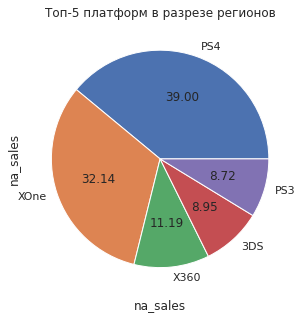

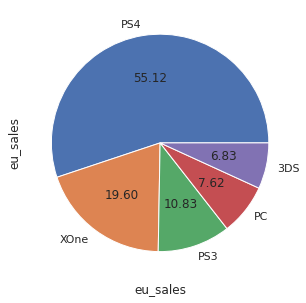

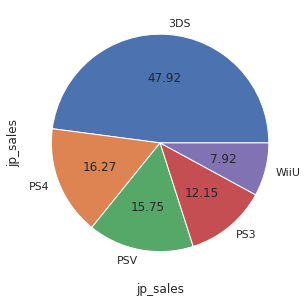

In [42]:
#найдем самые популярные платформы (топ-5) в разрезе регионов:
regions = ['na_sales', 'eu_sales', 'jp_sales']

plt.title('Топ-5 платформ в разрезе регионов')

for region in regions:
    sum_sales_platforms.groupby('platform')[region].sum() \
                       .sort_values(ascending=False) \
                       .head(5) \
                       .plot(kind='pie', y = region, autopct='%.2f', figsize=(12,5))
   
    
    plt.xlabel(region) 
    plt.show()  
    
    
   

Самой популярной платформой в Серверной Америке и Европе является PS4, при этом доля ее продаж в Европе значительно выше, чем в Северной Америке (на 16%). В то же время в Японии платформа PS4 является только второй по популярности с долей 16%. Самой популярной платформой в Японии является 3DS, ее доля в общем объеме продаж составляет практически половину.
Второй по популярности в Северной Америке и Европе является платформа XOne с долями продаж 32% и 20%. Остальные платформы имеют незначительные доли в суммарных продажах во всех трех регионах. 

<div class="alert alert-block alert-success">
 
### Комментарий ревьюера
    
#### Успех
    
Здесь хорошо опрелено и показано топ-5 по каждому региону. Отлично. 
</div 

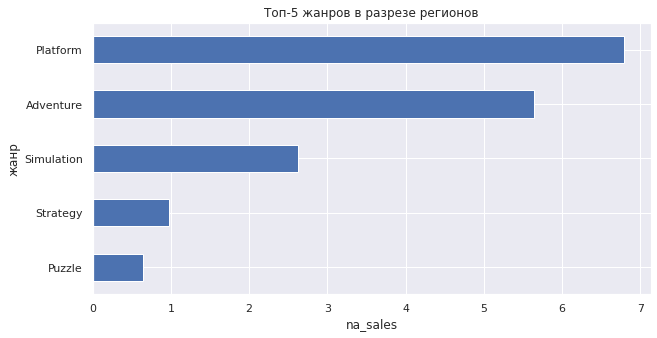

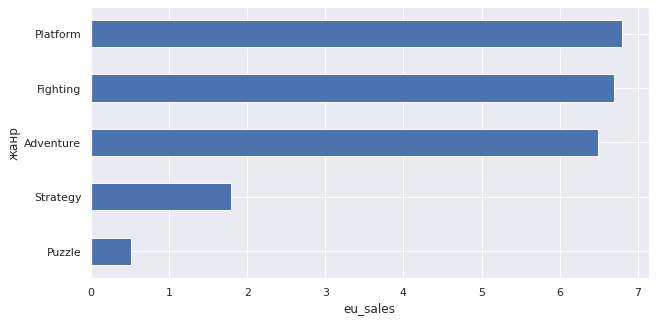

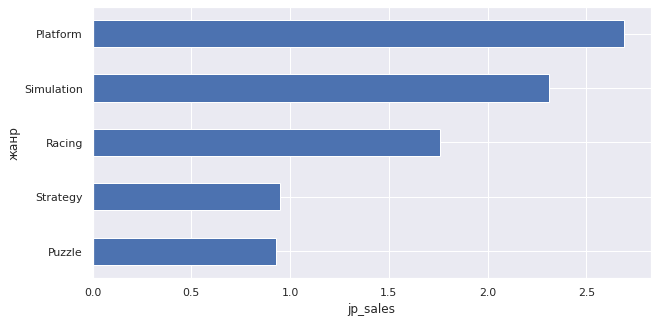

In [43]:
#найдем самые популярные жанры в разрезе регионов (топ-5):
regions = ['na_sales', 'eu_sales', 'jp_sales']

plt.title('Топ-5 жанров в разрезе регионов')

for region in regions:
    top_genre = sum_sales_platforms.groupby('genre')[region].sum() \
                       .sort_values(ascending=True) \
                       .head(5) \
                       .plot(kind='barh', y = region, figsize=(10,5))
   
    plt.ylabel('жанр')
    plt.xlabel(region) 
    plt.show()     
         

Во всех трех регионах на первом месте по популярности является жанр Platform, на 4-5 месте занимают игры жанров Strategy и Puzzle. 2-3 место по популярности в разных регионах занимают разные жанры: в Северной Америке - Adventure, Simulation, в Европе - Fighting и Adventure, в Японии - Simulation и Racing.

<div class="alert alert-block alert-success">
 
### Комментарий ревьюера
    
#### Успех
    
А тут особенно видно, что Япония наиболее уникальна. 
</div 

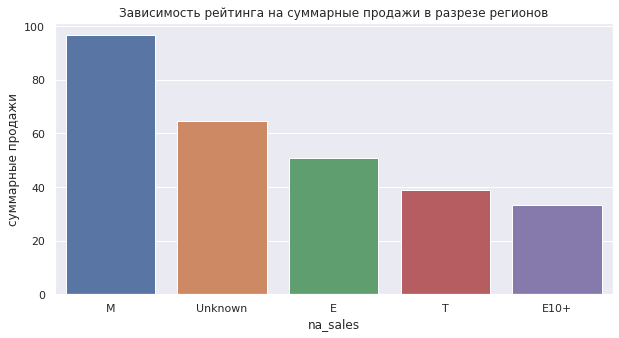

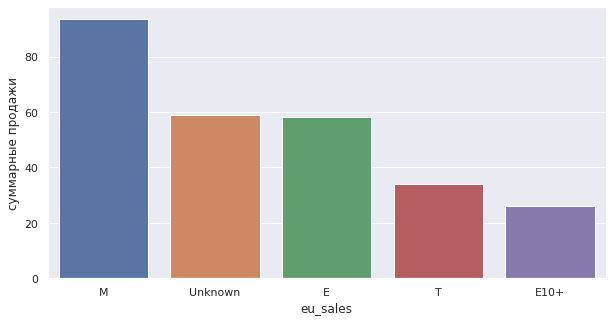

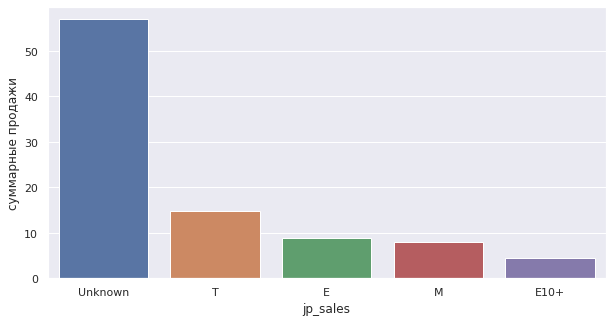

In [45]:
# определим влияет ли рейтинг на продажи в каждом отдельном регионе:
regions = ['na_sales', 'eu_sales', 'jp_sales']

plt.title('Зависимость рейтинга на суммарные продажи в разрезе регионов')
for region in regions:
    rating = (sum_sales_platforms.pivot_table(index= ('rating'), values= region, aggfunc='sum').reset_index()
                                .sort_values(region, ascending=False)
             )
    sns.barplot(data=rating, x='rating', y= region)  
    sns.set(rc={'figure.figsize':(10,5)})
    plt.xlabel( region)
    plt.ylabel('суммарные продажи')
    plt.show()     


Согласно графикам, распределение продаж в зависимости от рейтинга ESRB было схоже в Северной Америке и в Европе. В этих странах максимальные продажи компьютерных игр были для взрослых(M), на втором месте по уровню продаж были игры без рейтинга. Затем шли игры с рейтингом E (для всех), T(подростки) и минимальные продажи игр были с рейтингом E10+ (от 10+ и старше).
В Японии лидирующее место по продажам занимали игры без рейтинга (Unknown), превышая в 3,5 раз продажи игр всех остальных категорий. На втором месте находились продажи игр с рейтингом T (подростки), затем шли игры рейтинга E (для всех). В отличие от Северной Америки и Европы, в Японии игры с рейтингом M (для взрослых) отставали по продажам примерно в 10 раз, занимая только 4 место. Как и других регионах, продажи игр с рейтингом E10+ (от 10+ и старше) занимали последнюю строчку списка.

<b>4. Проверка гипотез</b>

- средние пользовательские рейтинги платформ Xbox One и PC одинаковые;
- средние пользовательские рейтинги жанров Action (англ. «действие», экшен-игры) и Sports (англ. «спортивные соревнования») разные.


<b>4.1 Проверка гипотезы "Средние пользовательские рейтинги платформ Xbox One и PC одинаковые".</b>

H_0 : "Среднее пользовательских рейтингов Xbox One и PC равны между собой" 

H_1: "Среднее пользовательских рейтингов двух Xbox One и PC не равны между собой"



In [46]:
# проверим  H0 гипотезу:

# убираем значения с пропусками:
games = sum_sales_platforms.loc[sum_sales_platforms['user_score'] != -1]

#отфильтруем по платформам:
game_pc = games.loc[games['platform'] == 'PC']
game_xone = games.loc[games['platform'] == 'XOne'] 

alpha = .05

results = st.ttest_ind(game_pc['user_score'], game_xone['user_score'], equal_var=False)
print('р-value:',results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
     print('Не получилось отвергнуть нулевую гипотезу')

р-value: 0.047722473435612776
Отвергаем нулевую гипотезу


<div class="alert alert-block alert-success">
 
### Комментарий ревьюера
    
#### Успех
    
Гипотезы сформулированы и верно определен метод проверки. 
</div 

<b>Вывод:<b/> 
    
p-value 0,047 показывает, что вероятность получить одинаковые средние пользовательские рейтинги для платформ Xbox One и PC составляет 4,7%. Это явно слишком маленькая вероятность, чтобы делать вывод о равенстве средних пользовательских отзывов двух платформ. 




<b> 4.2. Проверка гипотезы "Средние пользовательские рейтинги жанров Action и Sports разные".</b>

H_0: "Среднее пользовательских рейтингов жанров Action и Sports равны между собой"

H_1: "Среднее пользовательских рейтингов жанров Action и Sports не равны между собой"

In [47]:
# проверим  H0 гипотезу:

# убираем значения с пропусками:
games = sum_sales_platforms.loc[sum_sales_platforms['user_score'] != -1]

#отфильтруем по жанрам:
genre_action = games.loc[games['genre'] == 'Action']
genre_sports= games.loc[games['genre'] == 'Sports'] 

alpha = .05

results = st.ttest_ind(genre_action['user_score'], genre_sports['user_score'], equal_var=False)
print('р-value:',results.pvalue)

if results.pvalue < alpha:
    print('Отвергаем нулевую гипотезу')
else:
     print('Не получилось отвергнуть нулевую гипотезу')

р-value: 2.1579210941835162e-13
Отвергаем нулевую гипотезу


<b>Вывод:<b/> 

p-value очень мало и  показывает, что вероятность получить одинаковые средние пользовательские рейтинги жанров Action и Sports очень мала. 

<div class="alert alert-block alert-success">
 
### Комментарий ревьюера
    
#### Успех
    
И тут у меня нет замечаний. Умница. 
</div 

<b>Общий вывод:</b>

В ходе реализации проекта по анализу исторических данных о глобальных продажах компьютерных игр, оценок пользователей и экспертов до 2016 года в первую очередь были изучены исходные данные и сделана предобработка данных.

1. По результатам анализа исходных данных обнаружены пропуски в данных в 6 столбцах из 11. Самая большая доля пропусков содержится в столбцах: critic_score - 51%, user_score - 40%, rating - 41%. В столбце user_score присутствует значение tbd (to be determined) означающее, что решение по вопросу не принято. 


2. В результате предобработки исходных данных выполнены следующие действия:
- значение tbd заменено на Nan (нет данных);
- пропуски в столбцах critic_score и user_score заменены значением -1. Ввиду того, что доля пропусков  в этих столбцах  составляет половину от всей выборки и эти данные должны использоваться при дальнейшем анализе, данные удалять не допускается. 
- пропуски в столбце rating заменены на Unknown;
- пропуски из столбцов name и year_of_release удалены, по причине их несущественного количества (2 строки). 
- явные дубликаты в данных не обнаружены. 

В результате предобработки данных доля удаленных данных составила 1.6%.
Также был изменен тип данных в столбце year_reliase с float на int т.к. год это целое число. Данные в столбце user_score типа Object преобразованы в тип данных float т.к. оценки пользователей обычно вещественные числа с плавающей точкой.

3. По результатам исследовательского анализа данных выполнены следующие действия:
- построена гистограмма, показывающая общее количество компьютерных игр, выпущенных в период с 1980 до 2015 г.г. Согласно гистограмме развитие индустрии компьютерных игр началось после 1990 года. Выпуск игр достиг максимума в 2010-2011 г.г. Поэтому данные ранее 2000 года уже потеряли актуальность.

- в результате отбора 20 платформ с наибольшими суммарными продажами построен график распределения продаж по годам. В соответствии с полученным графиком появление новых платформ и исчезновение старых происходит примерно каждые 10 лет. Большинство платформ с наибольшими суммарными продажами появились и исчезали в последние 10 лет. Ввиду того, что производство компьютерных игр быстро изменяется за счет развития информационных технологий, сделан вывод о том, что актуальным периодом для проведения дальнейшего анализа необходимо считать 3 последних года (2014-2016 г.г.).

- за установленный актуальный период среди 10 платформ найдены две лидирующие по продажам платформы: PS4 и XOne, которые являются потенциально прибыльными.

- построена диаграмма размаха (ящик с усами) по глобальным продажам игр по двум потенциально прибыльным платформам (PS4 и XOne). Согласно диаграмме, ориентировочная граница нормального размаха заканчивается для платформы PS4 на значении 1,6 млн. рублей, для платформы XOne - 1,5 млн. рублей. Все значения, которые находятся выше этих значений являются выбросами. При этом степень разброса за пределами верхнего квартиля по обеим платформам намного больше, чем за пределами нижнего. Данные смещены в сторону меньших значений, так как медианы обеих платформ равны примерно 0,2 млн рублей и стремляться к короткому хвосту меньших значений. При этом 25% суммарных продаж по каждой платформе примерно равны 0,05 млн рублей. В то время как 75% суммарных продаж платформы PS4 равны 0,7 млн рублей, а платформы XOne - 0,6 млн рублей.

- проанализирована зависимость отзывов пользователей и критиков на продажи внутри платформы PS4. Согласно построенным диаграммам, а также исходя из полученных коэффициентов корреляции Пирсона можно сделать вывод, что зависимость между суммарными продажами и отзывами пользователей положительная, но очень слабая, так как значение коэффициента близко к нулю (corr=0,14-0,15).

- для сравнения результатов суммарных продаж платформ лидеров с другими платформами построена диаграмма размаха в разрезе трех предыдущих лет. Согласно диаграмме, медианные оценки суммарных продаж платформ-лидеров PS4 и XOne в 2014 году были максимальными среди всех платформ, после чего в 2015-2016 годах резко сократились, сравнявшись с уровнем суммарных продаж таких платформ как 3DS, PS3. При этом медианная оценка суммарных продаж платформы 3DS остается стабильной в течение уже трех лет. Также остается относительно стабильной в течение последних двух лет и медианная оценка суммарных продаж платформы WiiU, при этом в 2016 году данная платформа вышла в лидеры по суммарным продажам, обогнав остальных участников.  

- построено общее распределение игр по жанрам, согласно которому среди общего количества продаж игры жанра Shooter являются самыми прибыльными, средние продажи которых составили 1,3 млн рублей. Второе место занимают игры жанра Sports со средними продажами примерно 0,7 млн рублей. Средние продажи игр жанров Platform, Fighting, Pole-Playing, Racing находились примерно на одном уровне и составляли 0,5 млн. рублей. К самым неприбыльным жанрам можно отнести Puzzle, Strategy и Puzzle со средними продажами менее 0,2 млн. рублей.   

4. Для составления портрета пользователя каждого из трех регионов выполнено следующее:
- найдены  популярные платформы (топ-5) в каждом регионе и определены самые популярные из них в каждом регионе. Так, самой популярной платформой в Серверной Америке и Европе является PS4, при этом доля ее продаж в Европе значительно выше, чем в Северной Америке (на 16%). В то же время в Японии платформа PS4 является только второй по популярности с долей 16%. Самой популярной платформой в Японии является 3DS, ее доля в общем объеме продаж составляет практически половину. Второй по популярности в Северной Америке и Европе является платформа XOne с долями продаж 32% и 20%. Остальные платформы имеют незначительные доли в суммарных продажах во всех трех регионах. 

- найдены популярные жанры (топ-5) в каждом регионе и определены самые популярные из них в каждом регионе. В частности, во всех трех регионах на первом месте по популярности является жанр Platform, на 4-5 месте занимают игры жанров Strategy и Puzzle. 2-3 место по популярности в разных регионах занимают разные жанры: в Северной Америке - Adventure, Simulation, в Европе - Fighting и Adventure, в Японии - Simulation и Racing.

- оценено  влияние рейтинга ESRB на продажи в отдельном регионе. Согласно полученным графикам, распределение продаж в зависимости от рейтинга ESRB было схоже в Северной Америке и в Европе. В этих странах максимальные продажи компьютерных игр были для взрослых(M), на втором месте по уровню продаж были игры без рейтинга. Затем шли игры с рейтингом E (для всех), T(подростки) и минимальные продажи игр были с рейтингом E10+ (от 10+ и старше). В Японии лидирующее место по продажам занимали игры без рейтинга (Unknown), превышая в 3,5 раз продажи игр всех остальных категорий. На втором месте находились продажи игр с рейтингом T (подростки), затем шли игры рейтинга E (для всех). В отличие от Северной Америки и Европы, в Японии игры с рейтингом M (для взрослых) отставали по продажам примерно в 10 раз, занимая только 4 место. Как и других регионах, продажи игр с рейтингом E10+ (от 10+ и старше) занимали последнюю строчку списка.

5. Для проверки, о том, что одинаковые ли средние пользовательские рейтинги платформ Xbox One и PC и разные ли средние пользовательские рейтинги жанров Action и Sports были сформулированы нулевые и альтернативные гипотезы. В результате проверки гипотез установлено, что вероятность  получить одинаковые средние пользовательские рейтинги для платформ Xbox One и PC составляет 4,7% и является слишком маленькой, чтобы делать вывод о равенстве средних пользовательских отзывов двух платформ. Вероятность получить одинаковые средние пользовательские рейтинги жанров Action и Sports также оказалась очень мала. 

 
На основе проведенного исследовательского анализа можно сделать вывод, что потенциально прибыльными платформами компьютерных игр являются PS4 и XOne, однако в последний год (2016 г.)  суммарные продажи игр на этих платформах резко сократились и сравнялись с уровнем продаж игр на платформе 3DS и PS3. Игры жанров Shooter и Sports являются самыми прибыльными исходя из показателя средних продаж. 

Статистический анализ данных показал, что вероятность получить одинаковые средние пользовательские рейтинги платформ  Xbox One и PC и жанров Action и Sports мала.

<b>Портрет пользователя компьютерных игр в Северной Америки: </b>

-самые популярные платформы PS4 и XOne
-самые популярные жанры компьютерных игр Platform, Advanture и  Simulation
-лидеры продаж исходя из рейтинга ESRB игры для взрослых и без рейтинга.

<b>Портрет пользователя компьютерных игр в Европе:</b>

-самые популярные платформы PS4 и XOne
-самые популярные жанры компьютерных игр Platform, Fighting и  Advanture
-лидеры продаж исходя из рейтинга ESRB игры для взрослых и без рейтинга.

<b>Портрет пользователя компьютерных игр в Японии:</b>

-самые популярные платформы 3DS и PS4
-самые популярные жанры компьютерных игр Platform, Simulation и Racing
-лидеры продаж исходя из рейтинга ESRB игры без рейтинга и  для подростков.
 
 Полученные результаты помогут быть использованы для определения  потенциального продукта и планирования рекламных кампании в 2017 году. 


<div class="alert alert-block alert-success">
 
### Комментарий ревьюера
    
#### Успех
    
Тот момент, когда итоговый вывод стал отличныфм дополнением твоего проекта. С такими подробными данными не стыдно идти к заказчику. Теперь мы сможем составить прогноз на 2017. 
</div 

<div class="alert alert-block alert-info">

## Итоговый комментарии от ревьюера:

    
#### Успех

Очень классный проект ты сделала. Мне очень понравилось проверять твою работу. Ты применяешь правильные методы для работы с данными. В работе не содержится лишнего кода. Каждое действие подкреплено комментариями. С визуализациями у тебя тоже все отлично. Отдельно отмечу раздел по Знакомству с данными и Предобработке. Очень надеюсь, что и следующие проекты ты будешь выполнять на таком же высоком уровне.
    
Проект я принимаю и желаю тебе удачи в учебе.
</div>